In [1]:
import signature
import signature.tensor_algebra as ta

print(signature.__file__)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/phonedegerland/efmgate/external/signature/signature/__init__.py


In [4]:
# ===============================
# Seeds
# ===============================
import random
import numpy as np
import torch


# ============================================================
# Imports & Seeds
# ============================================================
from efmgate.models import EfmLSTM


import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

In [5]:
# Import des fonctions data
from efmgate.data import generate_ou_signal, build_dataset, split_data, r2_score

## CODE ALPHONSE


Run 1, n_ahead=1
Shapes - X_train: (69, 50, 1), y_train: (69, 50, 1)
Shapes - X_test:  (16, 50, 1),  y_test:  (16, 50, 1)
Epoch 5 | Val loss: 0.01924 | LR: 0.010000
Epoch 5 | Val loss: 0.01891 | LR: 0.010000
Epoch 5 | Val loss: 0.01865 | LR: 0.010000
Epoch 5 | Val loss: 0.01847 | LR: 0.010000
Epoch 5 | Val loss: 0.01830 | LR: 0.010000
Epoch 5 | Val loss: 0.01811 | LR: 0.010000
Epoch 5 | Val loss: 0.01771 | LR: 0.010000
Early stopping triggered at epoch 8
Early stopping triggered at epoch 3
y_pred_efm shape:    (16, 50, 1)
y_pred_simple shape: (16, 50, 1)
y_test shape:        (16, 50, 1)
Run 1 | EFM     R²: 0.7225, RMSE: 0.1201
Run 1 | Simple  R²: 0.7255, RMSE: 0.1195


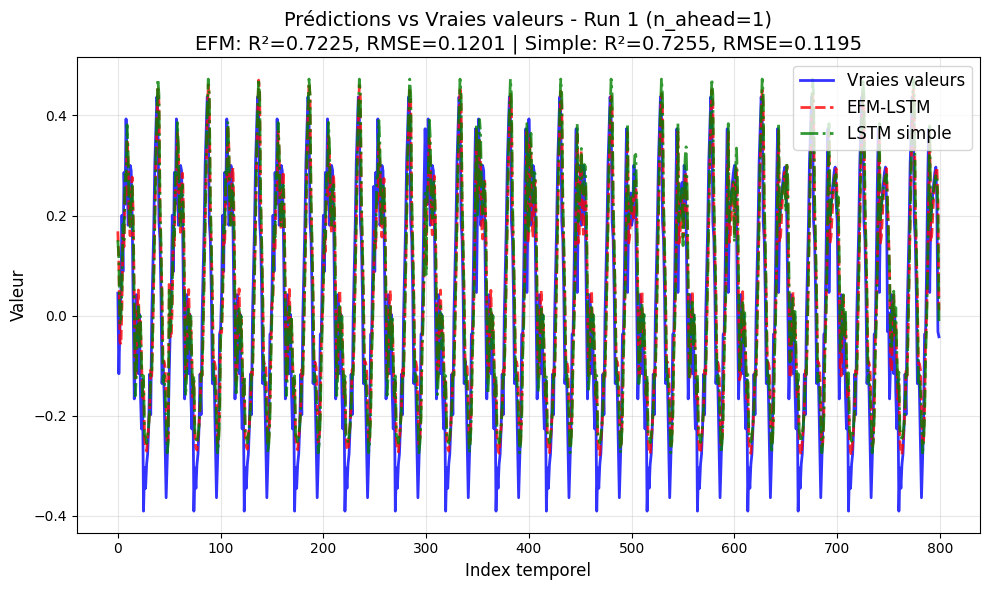


Run 2, n_ahead=1
Shapes - X_train: (69, 50, 1), y_train: (69, 50, 1)
Shapes - X_test:  (16, 50, 1),  y_test:  (16, 50, 1)
Early stopping triggered at epoch 1
Early stopping triggered at epoch 3
y_pred_efm shape:    (16, 50, 1)
y_pred_simple shape: (16, 50, 1)
y_test shape:        (16, 50, 1)
Run 2 | EFM     R²: -0.0183, RMSE: 0.2301
Run 2 | Simple  R²: 0.7320, RMSE: 0.1181


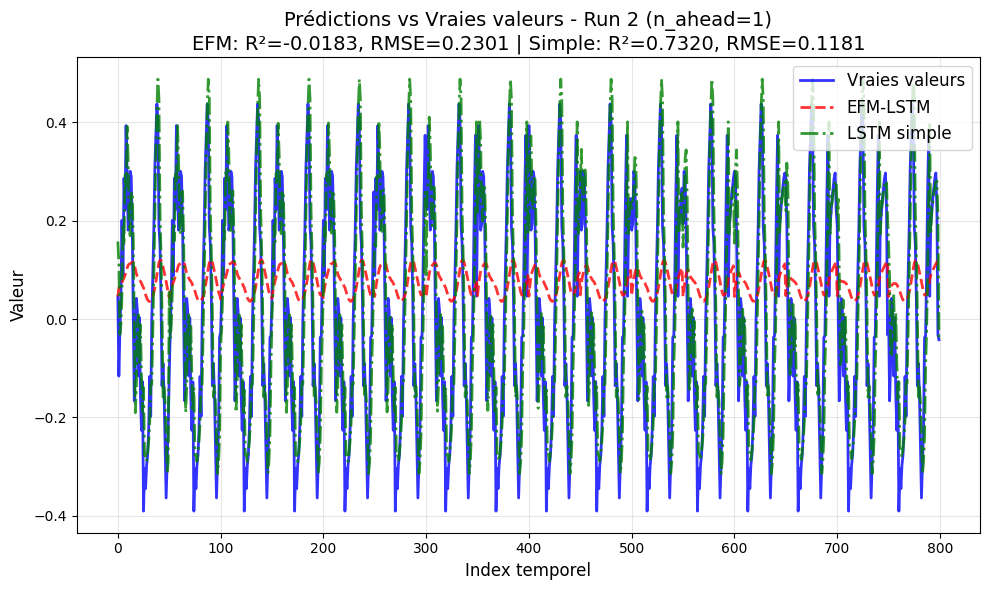


Run 3, n_ahead=1
Shapes - X_train: (69, 50, 1), y_train: (69, 50, 1)
Shapes - X_test:  (16, 50, 1),  y_test:  (16, 50, 1)


KeyboardInterrupt: 

In [6]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ============================================================
# Data generation
# ============================================================
_, data = generate_ou_signal(T=150, seed=0, kappa=15, theta=0., nu=1.5)
paths, targets = build_dataset(data.reshape(-1, 1))


# ============================================================
# Models
# ============================================================
class EfmLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1
    signature_depth: int = 2
    signature_input_size: int = 5

    @nn.compact
    def __call__(self, x):
        h = EfmLSTM(self.units, self.signature_depth, self.signature_input_size)(x)
        h = EfmLSTM(self.units, self.signature_depth, self.signature_input_size)(h)
        return nn.Dense(self.out_size)(h)


class SimpleLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1

    @nn.compact
    def __call__(self, x):
        """
        x: (batch, T, in_size)
        return: (batch, T, out_size)
        """
        batch_size, T, _ = x.shape
        cell = nn.LSTMCell(features=self.units)

        # ✅ INIT CARRY ROBUSTE (compatible toutes versions flax)
        c0 = jnp.zeros((batch_size, self.units), dtype=x.dtype)
        h0 = jnp.zeros((batch_size, self.units), dtype=x.dtype)
        carry = (c0, h0)

        hs = []
        for t in range(T):
            carry, h = cell(carry, x[:, t, :])
            hs.append(h)

        h_seq = jnp.stack(hs, axis=1)          # (batch, T, units)
        y = nn.Dense(self.out_size)(h_seq)     # (batch, T, out_size)
        return y


# ============================================================
# Generic training (works for both models)
# ============================================================
def train_model_generic(
    model, x_train, y_train, x_val, y_val,
    epochs=10, lr=0.01, batch_size=10,
    patience_es=5, min_delta=1e-5,
    lr_reduce_patience=5, lr_factor=0.25, min_lr=2.5e-5,
    seed=0
):
    params = model.init(jax.random.PRNGKey(seed), x_train)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, x, y):
        y_pred = model.apply(params, x)
        return jnp.mean((y_pred - y) ** 2)

    grad_fn = jax.value_and_grad(loss_fn)

    best_val_loss = float("inf")
    best_params = params
    epochs_no_improve_es = 0
    epochs_no_improve_lr = 0
    current_lr = lr

    num_batches = int(np.ceil(x_train.shape[0] / batch_size))

    for epoch in range(epochs):
        perm = np.random.permutation(x_train.shape[0])
        x_train_shuff = x_train[perm]
        y_train_shuff = y_train[perm]

        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size

            x_batch = x_train_shuff[start:end]
            y_batch = y_train_shuff[start:end]

            loss, grads = grad_fn(params, x_batch, y_batch)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

            # validation (à chaque batch comme dans ton code)
            val_loss = float(loss_fn(params, x_val, y_val))

            if best_val_loss - val_loss > min_delta:
                best_val_loss = val_loss
                best_params = params
                epochs_no_improve_es = 0
                epochs_no_improve_lr = 0
            else:
                epochs_no_improve_es += 1
                epochs_no_improve_lr += 1

            # reduce LR
            if epochs_no_improve_lr >= lr_reduce_patience:
                current_lr = max(current_lr * lr_factor, min_lr)
                optimizer = optax.adam(current_lr)
                opt_state = optimizer.init(params)
                epochs_no_improve_lr = 0

            # logs
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1} | Val loss: {val_loss:.5f} | LR: {current_lr:.6f}")

            # early stopping
            if epochs_no_improve_es >= patience_es:
                print(f"Early stopping triggered at epoch {epoch+1}")
                return model, best_params

    return model, best_params


# ============================================================
# Plot (single graph with 3 curves)
# ============================================================
def plot_predictions_simple(
    y_true, y_pred_efm, y_pred_simple,
    run_num, n_ahead=1,
    r2_efm=None, rmse_efm=None,
    r2_simple=None, rmse_simple=None
):
    plt.figure(figsize=(10, 6))

    y_true_np = np.array(y_true).flatten()
    y_efm_np = np.array(y_pred_efm).flatten()
    y_simple_np = np.array(y_pred_simple).flatten()

    plt.plot(y_true_np, 'b-', linewidth=2, label='Vraies valeurs', alpha=0.8)
    plt.plot(y_efm_np, 'r--', linewidth=2, label='EFM-LSTM', alpha=0.8)
    plt.plot(y_simple_np, 'g-.', linewidth=2, label='LSTM simple', alpha=0.8)

    plt.xlabel('Index temporel', fontsize=12)
    plt.ylabel('Valeur', fontsize=12)

    title = f'Prédictions vs Vraies valeurs - Run {run_num} (n_ahead={n_ahead})'
    if (r2_efm is not None and rmse_efm is not None and
        r2_simple is not None and rmse_simple is not None):
        title += (
            f"\nEFM: R²={r2_efm:.4f}, RMSE={rmse_efm:.4f} | "
            f"Simple: R²={r2_simple:.4f}, RMSE={rmse_simple:.4f}"
        )
    plt.title(title, fontsize=14)

    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# Main training loop
# ============================================================
n_aheads = [1]

results_r2_efm = {n: [] for n in n_aheads}
results_rmse_efm = {n: [] for n in n_aheads}
results_r2_simple = {n: [] for n in n_aheads}
results_rmse_simple = {n: [] for n in n_aheads}

all_predictions = []

for n_ahead in n_aheads:
    for run in range(3):
        print(f"\n{'='*50}")
        print(f"Run {run+1}, n_ahead={n_ahead}")
        print('='*50)

        # Split
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(paths, targets)
        X_train, y_train = jnp.array(X_train), jnp.array(y_train)
        X_val, y_val = jnp.array(X_val), jnp.array(y_val)
        X_test, y_test = jnp.array(X_test), jnp.array(y_test)

        print(f"Shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"Shapes - X_test:  {X_test.shape},  y_test:  {y_test.shape}")

        # ----------------------------
        # Train EFM-LSTM
        # ----------------------------
        efm_model = EfmLSTMPredictor()
        efm_model, efm_params = train_model_generic(
            efm_model, X_train, y_train, X_val, y_val,
            epochs=10, lr=0.01, batch_size=10,
            patience_es=5, min_delta=1e-5,
            lr_reduce_patience=5, lr_factor=0.25, min_lr=2.5e-5,
            seed=0
        )

        # ----------------------------
        # Train Simple LSTM
        # ----------------------------
        simple_model = SimpleLSTMPredictor(units=16)
        simple_model, simple_params = train_model_generic(
            simple_model, X_train, y_train, X_val, y_val,
            epochs=10, lr=0.01, batch_size=10,
            patience_es=5, min_delta=1e-5,
            lr_reduce_patience=5, lr_factor=0.25, min_lr=2.5e-5,
            seed=0
        )

        # ----------------------------
        # Predictions
        # ----------------------------
        y_pred_efm = efm_model.apply(efm_params, X_test)
        y_pred_simple = simple_model.apply(simple_params, X_test)

        print(f"y_pred_efm shape:    {y_pred_efm.shape}")
        print(f"y_pred_simple shape: {y_pred_simple.shape}")
        print(f"y_test shape:        {y_test.shape}")

        # ----------------------------
        # Metrics
        # ----------------------------
        r2_efm = r2_score(y_test, y_pred_efm)
        rmse_efm = jnp.sqrt(jnp.mean((y_pred_efm - y_test) ** 2))

        r2_simple = r2_score(y_test, y_pred_simple)
        rmse_simple = jnp.sqrt(jnp.mean((y_pred_simple - y_test) ** 2))

        results_r2_efm[n_ahead].append(float(r2_efm))
        results_rmse_efm[n_ahead].append(float(rmse_efm))
        results_r2_simple[n_ahead].append(float(r2_simple))
        results_rmse_simple[n_ahead].append(float(rmse_simple))

        print(f"Run {run+1} | EFM     R²: {r2_efm:.4f}, RMSE: {rmse_efm:.4f}")
        print(f"Run {run+1} | Simple  R²: {r2_simple:.4f}, RMSE: {rmse_simple:.4f}")

        # ----------------------------
        # Plot (3 curves, simple LSTM in GREEN)
        # ----------------------------
        y_test_flat = np.array(y_test).flatten()
        y_pred_efm_flat = np.array(y_pred_efm).flatten()
        y_pred_simple_flat = np.array(y_pred_simple).flatten()

        plot_predictions_simple(
            y_test_flat, y_pred_efm_flat, y_pred_simple_flat,
            run_num=run+1, n_ahead=n_ahead,
            r2_efm=float(r2_efm), rmse_efm=float(rmse_efm),
            r2_simple=float(r2_simple), rmse_simple=float(rmse_simple)
        )

        all_predictions.append({
            "run": run + 1,
            "n_ahead": n_ahead,
            "y_true": y_test_flat,
            "y_pred_efm": y_pred_efm_flat,
            "y_pred_simple": y_pred_simple_flat,
            "r2_efm": float(r2_efm),
            "rmse_efm": float(rmse_efm),
            "r2_simple": float(r2_simple),
            "rmse_simple": float(rmse_simple),
        })

In [ ]:
1+1

# Code Aimé

In [13]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
import numpy as np
import random
import matplotlib.pyplot as plt

# ===============================
# Random seed
# ===============================
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

# ===============================
# Data generation (OU example)
# ===============================
_, data = generate_ou_signal(T=150, seed=0, kappa=15, theta=0., nu=1.5)
paths, targets = build_dataset(data.reshape(-1, 1))

# ===============================
# Models
# ===============================
class EfmLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1
    signature_depth: int = 2
    signature_input_size: int = 5
    lam: float = 0.35 

    @nn.compact
    def __call__(self, x):
        h = EfmLSTM(self.units, self.signature_depth, self.signature_input_size,self.lam)(x)
        h = EfmLSTM(self.units, self.signature_depth, self.signature_input_size,self.lam)(h)
        return nn.Dense(self.out_size)(h)


class SimpleLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1

    @nn.compact
    def __call__(self, x):
        batch_size, T, _ = x.shape
        cell = nn.LSTMCell(features=self.units)
        c0 = jnp.zeros((batch_size, self.units), dtype=x.dtype)
        h0 = jnp.zeros((batch_size, self.units), dtype=x.dtype)
        carry = (c0, h0)
        hs = []
        for t in range(T):
            carry, h = cell(carry, x[:, t, :])
            hs.append(h)
        h_seq = jnp.stack(hs, axis=1)
        y = nn.Dense(self.out_size)(h_seq)
        return y

# ===============================
# Generic training with early stopping (per epoch)
# ===============================
def train_model_epoch_based(model, x_train, y_train, x_val, y_val,
                            epochs=50, lr=0.01, batch_size=10,
                            patience_es=5, min_delta=1e-5, seed=0):
    params = model.init(jax.random.PRNGKey(seed), x_train)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, x, y):
        y_pred = model.apply(params, x)
        return jnp.mean((y_pred - y) ** 2)

    grad_fn = jax.value_and_grad(loss_fn)
    best_val_loss = float("inf")
    best_params = params
    epochs_no_improve = 0
    current_lr = lr

    num_batches = int(np.ceil(x_train.shape[0] / batch_size))

    for epoch in range(epochs):
        # Shuffle at epoch start
        perm = np.random.permutation(x_train.shape[0])
        x_train_shuff = x_train[perm]
        y_train_shuff = y_train[perm]

        # Training loop
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            x_batch = x_train_shuff[start:end]
            y_batch = y_train_shuff[start:end]

            loss, grads = grad_fn(params, x_batch, y_batch)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

        # Validation at epoch end
        val_loss = float(loss_fn(params, x_val, y_val))

        # Early stopping check
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            best_params = params
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch+1} | Val loss: {val_loss:.5f}")

        if epochs_no_improve >= patience_es:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return model, best_params

# ===============================
# Multi-run experiment
# ===============================
n_ahead = 1 # 2 avant
num_runs = 4 
#results = {"SimpleLSTM": [], "EFM-LSTM": []}
results = { "EFM-LSTM": []}
#results_rmse = {"SimpleLSTM": [], "EFM-LSTM": []}
results_rmse = {"EFM-LSTM": []}
for run in range(num_runs):
    print(f"\n=== RUN {run+1} ===")

    # Split
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(paths, targets)
    X_train, y_train = jnp.array(X_train), jnp.array(y_train)
    X_val, y_val = jnp.array(X_val), jnp.array(y_val)
    X_test, y_test = jnp.array(X_test), jnp.array(y_test)

    # --- Simple LSTM ---
     #simple_model = SimpleLSTMPredictor(units=16)
     #simple_model, simple_params = train_model_epoch_based(
      #   simple_model, X_train, y_train, X_val, y_val,
       #  epochs=50, lr=0.01, batch_size=10, patience_es=5, seed=run
     #)
     #y_pred_simple = simple_model.apply(simple_params, X_test)
     #r2_simple = r2_score(y_test, y_pred_simple)
     #rmse_simple = jnp.sqrt(jnp.mean((y_test - y_pred_simple) ** 2))
     #results["SimpleLSTM"].append(float(r2_simple))
     #results_rmse["SimpleLSTM"].append(float(rmse_simple))

    # --- EFM-LSTM ---
    efm_model = EfmLSTMPredictor()
    efm_model, efm_params = train_model_epoch_based(
        efm_model, X_train, y_train, X_val, y_val,
        epochs=50, lr=0.01, batch_size=10, patience_es=5, seed=run
    )
    y_pred_efm = efm_model.apply(efm_params, X_test)
    r2_efm = r2_score(y_test, y_pred_efm)
    rmse_efm = jnp.sqrt(jnp.mean((y_test - y_pred_efm) ** 2))
    results["EFM-LSTM"].append(float(r2_efm))
    results_rmse["EFM-LSTM"].append(float(rmse_efm))

# ===============================
# Calculate mean and std
# ===============================
for model_name in results:
    mean_r2 = np.mean(results[model_name])
    mean_rmse = np.mean(results_rmse[model_name])
    print(f"{model_name} | Mean R²={mean_r2:.4f}, Mean RMSE={mean_rmse:.4f}")



=== RUN 1 ===
Epoch 1 | Val loss: 0.03949
Epoch 2 | Val loss: 0.03100
Epoch 3 | Val loss: 0.02555
Epoch 4 | Val loss: 0.01963
Epoch 5 | Val loss: 0.01714
Epoch 6 | Val loss: 0.01535
Epoch 7 | Val loss: 0.01438
Epoch 8 | Val loss: 0.01410
Epoch 9 | Val loss: 0.01404
Epoch 10 | Val loss: 0.01411
Epoch 11 | Val loss: 0.01434
Epoch 12 | Val loss: 0.01420
Epoch 13 | Val loss: 0.01406
Epoch 14 | Val loss: 0.01393
Epoch 15 | Val loss: 0.01422
Epoch 16 | Val loss: 0.01420
Epoch 17 | Val loss: 0.01404
Epoch 18 | Val loss: 0.01389
Epoch 19 | Val loss: 0.01400
Epoch 20 | Val loss: 0.01411
Epoch 21 | Val loss: 0.01397
Epoch 22 | Val loss: 0.01349
Epoch 23 | Val loss: 0.01350
Epoch 24 | Val loss: 0.01380
Epoch 25 | Val loss: 0.01327
Epoch 26 | Val loss: 0.01451
Epoch 27 | Val loss: 0.01372
Epoch 28 | Val loss: 0.01374
Epoch 29 | Val loss: 0.01394
Epoch 30 | Val loss: 0.01495
Early stopping triggered at epoch 30

=== RUN 2 ===
Epoch 1 | Val loss: 0.04604
Epoch 2 | Val loss: 0.02888
Epoch 3 | Val lo

KeyboardInterrupt: 